# ML DEFRA Data Preparation for Air Quality Prediction

This notebook prepares DEFRA data for machine learning models - mirrors LAQN ml_prep exactly.

## What this notebook does

1. Loads cleaned DEFRA data from the optimised folder.

   ```bash
   ├── optimised/
   │   ├── 2023measurements/
   │   │   ├── Station_Name/
   │   │   │   ├── NO2__2023_01.csv
   │   │   │   ├── PM10__2023_01.csv
   │   │   │   └── ...
   │   ├── 2024measurements/
   │   └── 2025measurements/
   ```

2. Combines all measurements into a single dataset.
3. Creates temporal features (hour, day, month).
4. Creates sequences for ML training.

## DEFRA CSV Structure

Each CSV file contains:
```
timestamp, value, timeseries_id, station_name, pollutant_name, pollutant_std, latitude, longitude
```

## Output path:

Data will be saved to: `data/defra/ml_prep/`

In [1]:
# Standard imports same as LAQN
import pandas as pd
import numpy as np
import os
from pathlib import Path

# Save section
import joblib

# Visualisation
import matplotlib.pyplot as plt

# Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## File Paths

- Usual drill, adding paths under this cell for organisation.

In [50]:
# DEFRA prep file paths
base_dir = Path.cwd().parent.parent / "data" / "defra"
project_root = Path.cwd() / "defra_ml_prep.ipynb"

# DEFRA optimised data path
optimised_path = base_dir / "optimised"

# Output paths
output_path = base_dir / "ml_prep"
output_path.mkdir(parents=True, exist_ok=True)

# Visualisation output path
visualisation_path = output_path / "visualisation"
visualisation_path.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {base_dir}")
print(f"Data path: {optimised_path}")
print(f"Output path: {output_path}")
print(f"Path exists: {optimised_path.exists()}")


# Define constants  top of notebook or before sequence creation
n_past = 12
n_future = 1

Base directory: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra
Data path: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/optimised
Output path: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep
Path exists: True


## 1) Load DEFRA data

DEFRA structure is nested: `optimised/YEARmeasurements/Station_Name/Pollutant__YYYY_MM.csv`

CSV columns: `timestamp, value, timeseries_id, station_name, pollutant_name, pollutant_std, latitude, longitude`

We'll map these to match LAQN column names for consistency:
- `timestamp` → `@MeasurementDateGMT`
- `value` → `@Value`
- `pollutant_std` → `SpeciesCode`
- `station_name` → `SiteCode` (with spaces replaced)

In [17]:
def load_defra_data(optimised_path):
    """
    Function to load the optimased data files from the defra dataset.

            optimised_path: path for data/defra/optimased directory.

    """
    optimised_path = Path(optimised_path)
    all_files = []
    file_count = 0
    
    # Get year measurement folders (2023measurements, 2024measurements, etc.)
    year_folders = sorted([f for f in optimised_path.iterdir() 
                          if f.is_dir() and 'measurements' in f.name])
    
    print(f"Found {len(year_folders)} year folders")
    
    for year_dir in year_folders:
        year_file_count = 0
        
        # Get station folders inside each year
        station_folders = sorted([f for f in year_dir.iterdir() if f.is_dir()])
        
        for station_dir in station_folders:
            # Get all CSV files in station folder
            for csv_file in station_dir.glob("*.csv"):
                try:
                    df = pd.read_csv(csv_file)
                    all_files.append(df)
                    file_count += 1
                    year_file_count += 1
                except Exception as e:
                    print(f"Error reading {csv_file.name}: {e}")
        
        print(f"  Loaded {year_dir.name}: {year_file_count} files")
    
    # Combine all dataframes
    if not all_files:
        raise ValueError(f"No CSV files found in {optimised_path}")
    
    combined_df = pd.concat(all_files, ignore_index=True)
    
    print(f"\n" + "="*40)
    print(f"Total files loaded: {file_count}")
    print(f"Total rows: {len(combined_df):,}")
    print(f"Columns: {list(combined_df.columns)}")
    
    return combined_df

In [18]:
# Load all defra data
df_raw = load_defra_data(optimised_path)
df_raw.head()

Found 3 year folders
  Loaded 2023measurements: 1431 files
  Loaded 2024measurements: 1193 files
  Loaded 2025measurements: 939 files

Total files loaded: 3563
Total rows: 2,525,991
Columns: ['timestamp', 'value', 'timeseries_id', 'station_name', 'pollutant_name', 'pollutant_std', 'latitude', 'longitude']


,timestamp,value,timeseries_id,station_name,pollutant_name,pollutant_std,latitude,longitude
0,2023-09-01 00:00:00,26.966,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
1,2023-09-01 01:00:00,27.349,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
2,2023-09-01 02:00:00,22.567,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
3,2023-09-01 04:00:00,17.021,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055
4,2023-09-01 05:00:00,23.141,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055


## 2) Rename columns to match LAQN format

This ensures the rest of the pipeline (from LAQN) works without changes.

| DEFRA Column | LAQN Column | Description |
|--------------|-------------|-------------|
| timestamp | @MeasurementDateGMT | Datetime |
| value | @Value | Measurement |
| pollutant_std | SpeciesCode | Pollutant code |
| station_name | SiteName | Station name |
| (derived) | SiteCode | Station code (no spaces) |

In [19]:
# Rename columns to match LAQN format
df_raw = df_raw.rename(columns={
    'timestamp': '@MeasurementDateGMT',
    'value': '@Value',
    'pollutant_std': 'SpeciesCode',
    'station_name': 'SiteName'
})

# Create SiteCode from SiteName (replace spaces with underscores)
df_raw['SiteCode'] = df_raw['SiteName'].str.replace(' ', '_')

print(f"Renamed columns: {df_raw.columns.tolist()}")
df_raw.head()

Renamed columns: ['@MeasurementDateGMT', '@Value', 'timeseries_id', 'SiteName', 'pollutant_name', 'SpeciesCode', 'latitude', 'longitude', 'SiteCode']


,@MeasurementDateGMT,@Value,timeseries_id,SiteName,pollutant_name,SpeciesCode,latitude,longitude,SiteCode
0,2023-09-01 00:00:00,26.966,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
1,2023-09-01 01:00:00,27.349,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
2,2023-09-01 02:00:00,22.567,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
3,2023-09-01 04:00:00,17.021,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park
4,2023-09-01 05:00:00,23.141,4566,Borehamwood Meadow Park,Nitrogen oxides,NOx,51.661229,-0.27055,Borehamwood_Meadow_Park


Renamed columns: ['@MeasurementDateGMT', '@Value', 'timeseries_id', 'SiteName', 'pollutant_name', 'SpeciesCode', 'latitude', 'longitude', 'SiteCode']

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>@MeasurementDateGMT</th>
      <th>@Value</th>
      <th>timeseries_id</th>
      <th>SiteName</th>
      <th>pollutant_name</th>
      <th>SpeciesCode</th>
      <th>latitude</th>
      <th>longitude</th>
      <th>SiteCode</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>2023-09-01 00:00:00</td>
      <td>26.966</td>
      <td>4566</td>
      <td>Borehamwood Meadow Park</td>
      <td>Nitrogen oxides</td>
      <td>NOx</td>
      <td>51.661229</td>
      <td>-0.27055</td>
      <td>Borehamwood_Meadow_Park</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2023-09-01 01:00:00</td>
      <td>27.349</td>
      <td>4566</td>
      <td>Borehamwood Meadow Park</td>
      <td>Nitrogen oxides</td>
      <td>NOx</td>
      <td>51.661229</td>
      <td>-0.27055</td>
      <td>Borehamwood_Meadow_Park</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2023-09-01 02:00:00</td>
      <td>22.567</td>
      <td>4566</td>
      <td>Borehamwood Meadow Park</td>
      <td>Nitrogen oxides</td>
      <td>NOx</td>
      <td>51.661229</td>
      <td>-0.27055</td>
      <td>Borehamwood_Meadow_Park</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2023-09-01 04:00:00</td>
      <td>17.021</td>
      <td>4566</td>
      <td>Borehamwood Meadow Park</td>
      <td>Nitrogen oxides</td>
      <td>NOx</td>
      <td>51.661229</td>
      <td>-0.27055</td>
      <td>Borehamwood_Meadow_Park</td>
    </tr>
    <tr>
      <th>4</th>
      <td>2023-09-01 05:00:00</td>
      <td>23.141</td>
      <td>4566</td>
      <td>Borehamwood Meadow Park</td>
      <td>Nitrogen oxides</td>
      <td>NOx</td>
      <td>51.661229</td>
      <td>-0.27055</td>
      <td>Borehamwood_Meadow_Park</td>
    </tr>
  </tbody>
</table>
</div>


## 3) Handle DEFRA Missing Value Flags

From your DEFRA report:
- DEFRA uses `-99` for maintenance/calibration
- DEFRA uses `-1` for invalid data
- Also has some negative values near detection limits (631 total, 0.025%)

Replace these with NaN for consistent handling.

In [20]:
def handle_flags(df, value_col='@Value'):
    """
    Replace defra quality flags with NaN.
    
    -99: Station maintenance or calibration
    -1: Other invalid data or insufficient capture
    Negative values: Near detection limit (replace with nan)
    """
    df = df.copy()
    
    # Count flags before replacement
    flag_99 = (df[value_col] == -99).sum()
    flag_1 = (df[value_col] == -1).sum()
    negative = (df[value_col] < 0).sum()
    
    print(f"defra quality flags found:")
    print(f"  -99 (maintenance): {flag_99:,} ({flag_99/len(df)*100:.2f}%)")
    print(f"  -1 (invalid): {flag_1:,} ({flag_1/len(df)*100:.2f}%)")
    print(f"  All negative values: {negative:,} ({negative/len(df)*100:.2f}%)")
    
    # Replace -99 and -1 flags with nan
    df[value_col] = df[value_col].replace([-99, -1], np.nan)
    
    # Replace remaining negative values with NaN (near detection limit)
    df.loc[df[value_col] < 0, value_col] = np.nan
    
    remaining_neg = (df[value_col] < 0).sum()
    print(f"\nAfter cleaning: {remaining_neg} negative values remain.")
    
    return df

# Apply flag handling
df_raw = handle_flags(df_raw)

defra quality flags found:
  -99 (maintenance): 0 (0.00%)
  -1 (invalid): 0 (0.00%)
  All negative values: 0 (0.00%)

After cleaning: 0 negative values remain.


defra quality flags found:
  -99 (maintenance): 0 (0.00%)
  -1 (invalid): 0 (0.00%)
  All negative values: 0 (0.00%)

After cleaning: 0 negative values remain.

## 4) Data exploration

Already checked data many times but I think it is beneficial to add it here again:

- How many unique stations? - **18**
- Which pollutants (species)? - **37 pollutants** (6 regulatory + 31 VOCs)
- Date range? - **01.01.2023 to 18.11.2025** (35 months)
- Total measurements? - **2,525,991 records**
- Data completeness? - **91.20%**

### Comparison with LAQN:

| Metric | LAQN | DEFRA |
|--------|------|-------|
| Stations | 78 | 18 |
| Pollutants | 6 | 37 |
| Completeness | 87.13% | 91.20% |
| Total records | 3,446,208 | 2,525,991 |

In [21]:
# Define colm names based on optimised data structure
date_col = '@MeasurementDateGMT'
value_col = '@Value'
site_col = 'SiteCode'
species_col = 'SpeciesCode'

# Convert datetime
df_raw[date_col] = pd.to_datetime(df_raw[date_col])

# run them.
print(f"Unique sites: {df_raw[site_col].nunique()}")
print(f"Unique species: {df_raw[species_col].nunique()}")
print(f"\nDate range: {df_raw[date_col].min()} to {df_raw[date_col].max()}")
print(f"\nSpecies in data:")
print(df_raw[species_col].value_counts())

Unique sites: 18
Unique species: 37

Date range: 2023-01-01 01:00:00 to 2025-11-09 23:00:00

Species in data:
SpeciesCode
NO2                326072
NO                 326061
NOx                325387
PM2.5              234748
PM10               227142
O3                 194333
SO2                 72928
CO                  48578
1,3,5-TMB           26649
i-Octane            26649
Benzene             26649
1,2,3-TMB           26649
Ethylbenzene        26649
Toluene             26649
o-Xylene            26649
n-Octane            26649
n-Heptane           26649
1,2,4-TMB           26649
Propane             26618
n-Pentane           26618
i-Pentane           26618
Ethene              26618
Propene             26618
Isoprene            26618
i-Hexane            26599
trans-2-Butene      26599
trans-2-Pentene     26599
n-Butane            26599
1-Butene            26599
i-Butane            26599
Ethane              26599
cis-2-Butene        26599
n-Hexane            26580
1-Pentene           

    Unique sites: 18
    Unique species: 37

    Date range: 2023-01-01 01:00:00 to 2025-11-09 23:00:00

    Species in data:
    SpeciesCode
    NO2                326072
    NO                 326061
    NOx                325387
    PM2.5              234748
    PM10               227142
    O3                 194333
    SO2                 72928
    CO                  48578
    1,3,5-TMB           26649
    i-Octane            26649
    Benzene             26649
    1,2,3-TMB           26649
    Ethylbenzene        26649
    Toluene             26649
    o-Xylene            26649
    n-Octane            26649
    n-Heptane           26649
    1,2,4-TMB           26649
    Propane             26618
    n-Pentane           26618
    i-Pentane           26618
    Ethene              26618
    Propene             26618
    Isoprene            26618
    i-Hexane            26599
    trans-2-Butene      26599
    trans-2-Pentene     26599
    n-Butane            26599
    1-Butene            26599
    i-Butane            26599
    Ethane              26599
    cis-2-Butene        26599
    n-Hexane            26580
    1-Pentene           26572
    1,3-Butadiene       26568
    Ethyne              26529
    m,p-Xylene          25503
    Name: count, dtype: int64

## 5) Selecting target pollutants

As documented in `/docs/DEFRA_data_quality.md` and `/docs/LAQN_DEFRA_benchmark.md`, DEFRA's highest coverage pollutants are:

| Pollutant | Stations | Coverage |
|-----------|----------|----------|
| PM10      | 15       | 10.42%   |
| PM2.5     | 15       | 10.42%   |
| NO2       | 14       | 9.72%    |
| NOx       | 14       | 9.72%    |
| NO        | 14       | 9.72%    |
| O3        | 9        | 6.25%    |

### Comparison with LAQN coverage:

| Pollutant | LAQN Sites | DEFRA Sites |
|-----------|------------|-------------|
| NO2       | 60         | 14          |
| PM2.5     | 53         | 15          |
| PM10      | 43         | 15          |
| O3        | 11         | 9           |

### Selected for ML training:

To enable direct comparison with LAQN results, filtering to:
- **NO2** (14 stations) - primary traffic pollutant
- **PM10** (15 stations) - particulate matter
- **O3** (9 stations) - secondary photochemical pollutant

**Note:** DEFRA has fewer stations (18 total vs LAQN's 78) but higher data completeness (91.2% vs 87.1%). This tests whether data quality compensates for spatial coverage.

In [22]:
# target pollutants
target_pollutants = ['NO2', 'PM25', 'PM10', 'O3']

# Filter data
df_filtered = df_raw[df_raw[species_col].isin(target_pollutants)].copy()

print(f"Rows before filtering: {len(df_raw):,}")
print(f"Rows after filtering: {len(df_filtered):,}")
print(f"\nPollutants included:")
print(df_filtered[species_col].value_counts())

Rows before filtering: 2,525,991
Rows after filtering: 747,547

Pollutants included:
SpeciesCode
NO2     326072
PM10    227142
O3      194333
Name: count, dtype: int64


    Rows before filtering: 2,525,991
    Rows after filtering: 747,547

    Pollutants included:
    SpeciesCode
    NO2     326072
    PM10    227142
    O3      194333
    Name: count, dtype: int64

### 5) Selecting Target Pollutant Results:

Comparison of LAQN and DEFRA metrics:

### Filtering results:

| Metric | Before | After |
|--------|--------|-------|
| Total rows | 2,525,991 | 747,547 |
| Pollutants | 37 | 3 |
| Data retained | 100% | 29.6% |

### Selected pollutants breakdown:

| Pollutant | Records | Percentage | Stations |
|-----------|---------|------------|----------|
| NO2 | 326,072 | 43.6% | 14 |
| PM10 | 227,142 | 30.4% | 15 |
| O3 | 194,333 | 26.0% | 9 |

### Why these three?

1. **Direct comparison with LAQN** - same pollutants used in LAQN small sample training
2. **Regulatory relevance** - NO2, PM10, O3 are key UK Air Quality Standards pollutants
3. **Sufficient coverage** - 9-15 stations per pollutant provides spatial diversity

### Comparison with LAQN filtered data:

| Aspect | LAQN | DEFRA |
|--------|------|-------|
| Rows after filter | ~3.4M | 747,547 |
| NO2 stations | 60 | 14 |
| PM10 stations | 43 | 15 |
| O3 stations | 11 | 9 |

**Note:** DEFRA has ~4.5x fewer records after filtering, but higher per-station completeness. This tests whether quality > quantity for ML performance.

## 6) Temporal feature adding

Already added this feature in analysis part.

Temporal features help the model understand pollution patterns:

- **Hour of day** - captures rush hour peaks (morning 7-9am, evening 5-7pm)
- **Day of week** - weekday vs weekend traffic differences
- **Month/Season** - seasonal variations (winter inversions, summer ozone)
- **Is weekend** - binary flag for traffic pattern changes

These features help the model learn when pollution is typically high or low.

### DEFRA seasonal patterns (from seasonal_averages.csv):

| Pollutant | Winter | Spring | Summer | Autumn | Pattern |
|-----------|--------|--------|--------|--------|---------|
| NO2 (µg/m³) | 25.43 | 20.42 | 15.51 | 22.86 | Winter peak |
| PM10 (µg/m³) | 14.14 | 15.03 | 11.34 | 12.45 | Spring peak |
| PM2.5 (µg/m³) | 9.00 | 8.99 | 5.92 | 7.38 | Winter peak |
| O3 (µg/m³) | 38.78 | 55.40 | 51.25 | 38.60 | Spring/Summer peak |

**Key observations:**
- **NO2** highest in winter (25.43), lowest in summer (15.51) - heating emissions + reduced dispersion
- **PM10** highest in spring (15.03), lowest in summer (11.34) - combustion + stagnant air
- **PM2.5** highest in winter (9.00), lowest in summer (5.92) - domestic burning + temperature inversions
- **O3** highest in spring (55.40), lowest in autumn (38.60) - photochemical formation from sunlight

**Note:** DEFRA's 91.2% completeness means fewer gaps in temporal sequences compared to LAQN, potentially improving the model's ability to learn these patterns.

In [23]:
def temporal_features(df, datetime_col):
    """
     Temporal features from datetime column.
    Param:
            df : pandas.DataFrame

            datetime_col : str
       
    """
    df = df.copy()
    
    #  datetime type needs to be ensured
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    
    # Extract features
    df['hour'] = df[datetime_col].dt.hour
    df['day_of_week'] = df[datetime_col].dt.dayofweek  # 0=Monday, 6=Sunday
    df['month'] = df[datetime_col].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    print("Added temporal features: hour, day_of_week, month, is_weekend")
    
    return df

In [24]:
# Add temporal features
df_temporal = temporal_features(df_filtered, date_col)

# Preview
df_temporal[['hour', 'day_of_week', 'month', 'is_weekend']].head()

Added temporal features: hour, day_of_week, month, is_weekend


,hour,day_of_week,month,is_weekend
2918,1,6,1,1
2919,2,6,1,1
2920,3,6,1,1
2921,4,6,1,1
2922,5,6,1,1


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>hour</th>
      <th>day_of_week</th>
      <th>month</th>
      <th>is_weekend</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2918</th>
      <td>1</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2919</th>
      <td>2</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2920</th>
      <td>3</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2921</th>
      <td>4</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>2922</th>
      <td>5</td>
      <td>6</td>
      <td>1</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

Added temporal features: hour, day_of_week, month, is_weekend


## 7) Wide formatting

For ml (Air quality prediction using CNN+LSTM-based hybrid deep learning architecture', *Environmental Science and Pollution Research*, 29(8), pp. 11920-11938)

And according to their search here are the findings:
 | Method      | Input                                    | Output           |
| ----------- | ---------------------------------------- | ---------------- |
| UNI/UNI     | Historical info of target pollutant only | Single pollutant |
| MULTI/UNI   | Historical info of all pollutants        | Single pollutant |
| MULTI/MULTI | Historical info of all pollutants        | All pollutants   |

page 11922 (Results section):

> "The multivariate model without using meteorological data revealed the best results."

So order to create multivariate input I will be formatting pivot to wider,adding each station/species combination to table.




In [25]:
def wide_format(df, datetime_col, site_col, species_col, value_col):
    """
    Pivot data from long to wide format. 
    Each site-species combination becomes a column.
    Each row represents one timestamp.
    
    Params:
        datetime_col, site_col, species_col, value_col 
    """
    df = df.copy()
    
    # Create site_species identifier
    df['site_species'] = df[site_col] + '_' + df[species_col]
    
    # Pivot table
    # If duplicate datetime-site_species combinations exist, take mean
    pivoted = df.pivot_table(
        index=datetime_col,
        columns='site_species',
        values=value_col,
        aggfunc='mean'
    )
    
    # Sort by datetime
    pivoted = pivoted.sort_index()
    
    print(f"Created wide format:")
    print(f"Timestamps: {len(pivoted):,}")
    print(f"Features (site-species): {len(pivoted.columns)}")
    print(f"Date range: {pivoted.index.min()} to {pivoted.index.max()}")
    
    return pivoted

In [26]:
# Create wide format
df_wide = wide_format(df_temporal, date_col, site_col, species_col, value_col)

# Preview
print("\nFirst 10 columns:")
print(list(df_wide.columns)[:10])
df_wide.head()

Created wide format:
Timestamps: 24,355
Features (site-species): 37
Date range: 2023-01-01 01:00:00 to 2025-11-09 23:00:00

First 10 columns:
['Borehamwood_Meadow_Park_NO2', 'Borehamwood_Meadow_Park_PM10', 'Camden_Kerbside_NO2', 'Camden_Kerbside_PM10', 'Ealing_Horn_Lane_PM10', 'Haringey_Roadside_NO2', 'London_Bexley_NO2', 'London_Bexley_PM10', 'London_Bloomsbury_NO2', 'London_Bloomsbury_O3']


site_species,Borehamwood_Meadow_Park_NO2,Borehamwood_Meadow_Park_PM10,Camden_Kerbside_NO2,Camden_Kerbside_PM10,Ealing_Horn_Lane_PM10,Haringey_Roadside_NO2,London_Bexley_NO2,London_Bexley_PM10,London_Bloomsbury_NO2,London_Bloomsbury_O3,...,London_N._Kensington_NO2,London_N._Kensington_O3,London_N._Kensington_PM10,London_Norbury_Manor_School_PM10,London_Teddington_Bushy_Park_PM10,London_Westminster_NO2,London_Westminster_O3,Southwark_A2_Old_Kent_Road_NO2,Southwark_A2_Old_Kent_Road_PM10,Tower_Hamlets_Roadside_NO2
@MeasurementDateGMT,,,,,,,,,,,,,,,,,,,,,
2023-01-01 01:00:00,4.781,8.5,7.268,22.223,NaN,12.240,1.530,NaN,5.293,67.721,...,2.104,65.259,10.7,NaN,8.550,8.396,NaN,5.546,22.223,5.355
2023-01-01 02:00:00,5.164,8.0,9.563,8.696,NaN,8.033,2.678,NaN,4.587,70.448,...,1.721,66.457,8.7,NaN,11.300,7.254,NaN,4.973,10.628,4.781
2023-01-01 03:00:00,2.678,8.8,5.546,14.493,NaN,6.311,1.339,NaN,3.732,70.598,...,0.956,68.053,10.9,NaN,13.350,5.865,NaN,4.399,12.561,6.311
2023-01-01 04:00:00,2.486,11.3,4.973,17.392,NaN,5.737,1.339,NaN,2.963,72.893,...,0.574,69.650,12.9,NaN,15.725,4.864,NaN,3.825,16.425,3.825
2023-01-01 05:00:00,2.869,11.4,5.164,16.425,NaN,7.459,1.530,NaN,3.300,70.847,...,1.147,67.854,14.8,NaN,17.550,4.195,NaN,3.634,20.290,3.442


Created wide format:
Timestamps: 24,355
Features (site-species): 37
Date range: 2023-01-01 01:00:00 to 2025-11-09 23:00:00

First 10 columns:
['Borehamwood_Meadow_Park_NO2', 'Borehamwood_Meadow_Park_PM10', 'Camden_Kerbside_NO2', 'Camden_Kerbside_PM10', 'Ealing_Horn_Lane_PM10', 'Haringey_Roadside_NO2', 'London_Bexley_NO2', 'London_Bexley_PM10', 'London_Bloomsbury_NO2', 'London_Bloomsbury_O3']

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>site_species</th>
      <th>Borehamwood_Meadow_Park_NO2</th>
      <th>Borehamwood_Meadow_Park_PM10</th>
      <th>Camden_Kerbside_NO2</th>
      <th>Camden_Kerbside_PM10</th>
      <th>Ealing_Horn_Lane_PM10</th>
      <th>Haringey_Roadside_NO2</th>
      <th>London_Bexley_NO2</th>
      <th>London_Bexley_PM10</th>
      <th>London_Bloomsbury_NO2</th>
      <th>London_Bloomsbury_O3</th>
      <th>...</th>
      <th>London_N._Kensington_NO2</th>
      <th>London_N._Kensington_O3</th>
      <th>London_N._Kensington_PM10</th>
      <th>London_Norbury_Manor_School_PM10</th>
      <th>London_Teddington_Bushy_Park_PM10</th>
      <th>London_Westminster_NO2</th>
      <th>London_Westminster_O3</th>
      <th>Southwark_A2_Old_Kent_Road_NO2</th>
      <th>Southwark_A2_Old_Kent_Road_PM10</th>
      <th>Tower_Hamlets_Roadside_NO2</th>
    </tr>
    <tr>
      <th>@MeasurementDateGMT</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2023-01-01 01:00:00</th>
      <td>4.781</td>
      <td>8.5</td>
      <td>7.268</td>
      <td>22.223</td>
      <td>NaN</td>
      <td>12.240</td>
      <td>1.530</td>
      <td>NaN</td>
      <td>5.293</td>
      <td>67.721</td>
      <td>...</td>
      <td>2.104</td>
      <td>65.259</td>
      <td>10.7</td>
      <td>NaN</td>
      <td>8.550</td>
      <td>8.396</td>
      <td>NaN</td>
      <td>5.546</td>
      <td>22.223</td>
      <td>5.355</td>
    </tr>
    <tr>
      <th>2023-01-01 02:00:00</th>
      <td>5.164</td>
      <td>8.0</td>
      <td>9.563</td>
      <td>8.696</td>
      <td>NaN</td>
      <td>8.033</td>
      <td>2.678</td>
      <td>NaN</td>
      <td>4.587</td>
      <td>70.448</td>
      <td>...</td>
      <td>1.721</td>
      <td>66.457</td>
      <td>8.7</td>
      <td>NaN</td>
      <td>11.300</td>
      <td>7.254</td>
      <td>NaN</td>
      <td>4.973</td>
      <td>10.628</td>
      <td>4.781</td>
    </tr>
    <tr>
      <th>2023-01-01 03:00:00</th>
      <td>2.678</td>
      <td>8.8</td>
      <td>5.546</td>
      <td>14.493</td>
      <td>NaN</td>
      <td>6.311</td>
      <td>1.339</td>
      <td>NaN</td>
      <td>3.732</td>
      <td>70.598</td>
      <td>...</td>
      <td>0.956</td>
      <td>68.053</td>
      <td>10.9</td>
      <td>NaN</td>
      <td>13.350</td>
      <td>5.865</td>
      <td>NaN</td>
      <td>4.399</td>
      <td>12.561</td>
      <td>6.311</td>
    </tr>
    <tr>
      <th>2023-01-01 04:00:00</th>
      <td>2.486</td>
      <td>11.3</td>
      <td>4.973</td>
      <td>17.392</td>
      <td>NaN</td>
      <td>5.737</td>
      <td>1.339</td>
      <td>NaN</td>
      <td>2.963</td>
      <td>72.893</td>
      <td>...</td>
      <td>0.574</td>
      <td>69.650</td>
      <td>12.9</td>
      <td>NaN</td>
      <td>15.725</td>
      <td>4.864</td>
      <td>NaN</td>
      <td>3.825</td>
      <td>16.425</td>
      <td>3.825</td>
    </tr>
    <tr>
      <th>2023-01-01 05:00:00</th>
      <td>2.869</td>
      <td>11.4</td>
      <td>5.164</td>
      <td>16.425</td>
      <td>NaN</td>
      <td>7.459</td>
      <td>1.530</td>
      <td>NaN</td>
      <td>3.300</td>
      <td>70.847</td>
      <td>...</td>
      <td>1.147</td>
      <td>67.854</td>
      <td>14.8</td>
      <td>NaN</td>
      <td>17.550</td>
      <td>4.195</td>
      <td>NaN</td>
      <td>3.634</td>
      <td>20.290</td>
      <td>3.442</td>
    </tr>
  </tbody>
</table>
<p>5 rows × 37 columns</p>
</div>

## 8) NaN value handling

DEFRA dataset has 91.2% completeness (vs LAQN's 87.1%), but still need to handle missing values.

### Strategy:

1. **Remove high-missing columns** - drop site-species combinations with >30% missing
2. **Interpolate small gaps** - linear interpolation for gaps up to 5 hours
3. **Drop remaining NaN rows** - remove rows that still have missing values

### DEFRA-specific considerations:

From the data quality report, missing values are unevenly distributed:

| Station | Issue | Missing % |
|---------|-------|-----------|
| London Eltham | PM10 equipment failure | 97.09% |
| London Teddington | PM sensor maintenance | ~43% |
| Other stations | Normal gaps | <5% |

These problematic station-pollutant combinations will be automatically removed in step 1 (>30% missing threshold).

### Why this approach?

- **Interpolation limit of 5 hours** - pollution patterns are autocorrelated, so short gaps can be reasonably estimated
- **30% threshold** - keeps stations with genuine data while removing equipment failures
- **No imputation for long gaps** - avoids introducing artificial patterns that could mislead the model


In [27]:
# Check missing values before handling
missing_pct = (df_wide.isnull().sum() / len(df_wide) * 100).sort_values(ascending=False)

print("Missing value percentage by column (top 20):")
print(missing_pct.head(20))

print(f"\nTotal cells: {df_wide.size:,}")
print(f"Missing cells: {df_wide.isnull().sum().sum():,}")
print(f"Missing percentage: {df_wide.isnull().sum().sum() / df_wide.size * 100:.2f}%")

Missing value percentage by column (top 20):
site_species
London_Eltham_PM10                      97.992199
London_Marylebone_Road_PM10             92.925477
Southwark_A2_Old_Kent_Road_PM10         91.923630
London_N._Kensington_PM10               91.336481
Ealing_Horn_Lane_PM10                   91.258468
Camden_Kerbside_PM10                    90.704168
London_Eltham_NO2                       85.001026
London_Eltham_O3                        82.328064
London_Norbury_Manor_School_PM10        82.254157
London_Honor_Oak_Park_O3                60.156025
London_Teddington_Bushy_Park_PM10       43.338124
London_Haringey_Priory_Park_South_O3    33.832889
Tower_Hamlets_Roadside_NO2              26.043933
London_Bexley_PM10                      16.822008
Haringey_Roadside_NO2                   15.524533
London_Harlington_O3                    10.737015
London_Marylebone_Road_O3               10.075960
London_Marylebone_Road_NO2               9.357421
London_Bloomsbury_PM10                   7

    Missing value percentage by column (top 20):
    site_species
    London_Eltham_PM10                      97.992199
    London_Marylebone_Road_PM10             92.925477
    Southwark_A2_Old_Kent_Road_PM10         91.923630
    London_N._Kensington_PM10               91.336481
    Ealing_Horn_Lane_PM10                   91.258468
    Camden_Kerbside_PM10                    90.704168
    London_Eltham_NO2                       85.001026
    London_Eltham_O3                        82.328064
    London_Norbury_Manor_School_PM10        82.254157
    London_Honor_Oak_Park_O3                60.156025
    London_Teddington_Bushy_Park_PM10       43.338124
    London_Haringey_Priory_Park_South_O3    33.832889
    Tower_Hamlets_Roadside_NO2              26.043933
    London_Bexley_PM10                      16.822008
    Haringey_Roadside_NO2                   15.524533
    London_Harlington_O3                    10.737015
    London_Marylebone_Road_O3               10.075960
    London_Marylebone_Road_NO2               9.357421
    London_Bloomsbury_PM10                   7.448163
    London_Westminster_O3                    7.242866
    dtype: float64

    Total cells: 901,135
    Missing cells: 266,521
    Missing percentage: 29.58%

### Results show problematic stations:

| Station                    | Pollutant | Missing % | Issue             |
| -------------------------- | --------- | --------- | ----------------- |
| London Eltham              | PM10      | 97.99%    | Equipment failure |
| London Marylebone Road     | PM10      | 92.93%    | Sensor issues     |
| Southwark A2 Old Kent Road | PM10      | 91.92%    | Sensor issues     |
| London Eltham              | NO2       | 85.00%    | Equipment failure |
| London Eltham              | O3        | 82.33%    | Equipment failure |

**Note:** London Eltham station has severe equipment failures across all pollutants - this was documented in the DEFRA data quality report.

## 8.A) Optimal columns and handle missing values

### The problem

I have 38 site/species colms but their missing values occur at different times.
When any column has a gap at a timestamp, that entire row is dropped.

- With all 38 columns: very few complete rows due to London Eltham failures
- Need to find balance between columns (features) and rows (samples)

### Where is the sweet spot?

I'll test different numbers of columns to maximise total data points (rows × columns):

In [28]:
# Testing different numbers of columns to find optimal balance
coverage = df_wide.notna().sum() / len(df_wide)
coverage_sorted = coverage.sort_values(ascending=False)

print("Columns vs Rows")
print("-" * 40)

results = []
for n_cols in [5, 10, 15, 20, 25, 30, 35, 38]:
    best_cols = coverage_sorted.head(n_cols).index
    df_test = df_wide[best_cols].copy()
    df_test = df_test.interpolate(method='linear', limit=5, limit_direction='both')
    df_test = df_test.dropna()
    
    total_data = len(df_test) * n_cols
    results.append({'columns': n_cols, 'rows': len(df_test), 'total': total_data})
    
    print(f"{n_cols} columns: {len(df_test):,} rows → {total_data:,} total data points")

# Find sweetest spot 
best = max(results, key=lambda x: x['total'])
print(f"\nOptimal: {best['columns']} columns with {best['rows']:,} rows")

Columns vs Rows
----------------------------------------
5 columns: 23,930 rows → 119,650 total data points
10 columns: 22,494 rows → 224,940 total data points
15 columns: 20,284 rows → 304,260 total data points
20 columns: 15,924 rows → 318,480 total data points
25 columns: 8,665 rows → 216,625 total data points
30 columns: 0 rows → 0 total data points
35 columns: 0 rows → 0 total data points
38 columns: 0 rows → 0 total data points

Optimal: 20 columns with 15,924 rows


    Columns vs Rows
    ----------------------------------------
    5 columns: 23,930 rows → 119,650 total data points
    10 columns: 22,494 rows → 224,940 total data points
    15 columns: 20,284 rows → 304,260 total data points
    20 columns: 15,924 rows → 318,480 total data points
    25 columns: 8,665 rows → 216,625 total data points
    30 columns: 0 rows → 0 total data points
    35 columns: 0 rows → 0 total data points
    38 columns: 0 rows → 0 total data points

    Optimal: 20 columns with 15,924 rows    

I will also check pollutants in selected colm, to see the pollutants I choose actually good mix.

In [29]:
# Pollutant check in selected columns
n_cols = best['columns']

best_cols = coverage_sorted.head(n_cols).index.tolist()

print(f"Selected {n_cols} columns:\n")
for col in best_cols:
    print(f"  {col}: {coverage_sorted[col]*100:.1f}% coverage")

# Count by pollutant type
no2 = [c for c in best_cols if 'NO2' in c]
pm10 = [c for c in best_cols if 'PM10' in c]
o3 = [c for c in best_cols if 'O3' in c]

print(f"\nPollutant mix:")
print(f"  NO2 stations: {len(no2)}")
print(f"  PM10 stations: {len(pm10)}")
print(f"  O3 stations: {len(o3)}")

Selected 20 columns:

  London_Hillingdon_O3: 99.1% coverage
  London_Harlington_PM10: 99.1% coverage
  London_Hillingdon_NO2: 98.8% coverage
  London_Westminster_NO2: 98.8% coverage
  London_Honor_Oak_Park_PM10: 98.5% coverage
  London_N._Kensington_NO2: 98.3% coverage
  Camden_Kerbside_NO2: 98.0% coverage
  London_Hillingdon_PM10: 97.8% coverage
  Southwark_A2_Old_Kent_Road_NO2: 97.4% coverage
  Borehamwood_Meadow_Park_NO2: 97.3% coverage
  London_Bloomsbury_NO2: 96.9% coverage
  London_Harlington_NO2: 96.6% coverage
  Borehamwood_Meadow_Park_PM10: 96.3% coverage
  London_Bloomsbury_O3: 95.7% coverage
  London_N._Kensington_O3: 95.5% coverage
  London_Haringey_Priory_Park_South_NO2: 95.1% coverage
  London_Bexley_NO2: 92.8% coverage
  London_Westminster_O3: 92.8% coverage
  London_Bloomsbury_PM10: 92.6% coverage
  London_Marylebone_Road_NO2: 90.6% coverage

Pollutant mix:
  NO2 stations: 11
  PM10 stations: 5
  O3 stations: 4


    Selected 20 columns:

    London_Hillingdon_O3: 99.1% coverage
    London_Harlington_PM10: 99.1% coverage
    London_Hillingdon_NO2: 98.8% coverage
    London_Westminster_NO2: 98.8% coverage
    London_Honor_Oak_Park_PM10: 98.5% coverage
    London_N._Kensington_NO2: 98.3% coverage
    Camden_Kerbside_NO2: 98.0% coverage
    London_Hillingdon_PM10: 97.8% coverage
    Southwark_A2_Old_Kent_Road_NO2: 97.4% coverage
    Borehamwood_Meadow_Park_NO2: 97.3% coverage
    London_Bloomsbury_NO2: 96.9% coverage
    London_Harlington_NO2: 96.6% coverage
    Borehamwood_Meadow_Park_PM10: 96.3% coverage
    London_Bloomsbury_O3: 95.7% coverage
    London_N._Kensington_O3: 95.5% coverage
    London_Haringey_Priory_Park_South_NO2: 95.1% coverage
    London_Bexley_NO2: 92.8% coverage
    London_Westminster_O3: 92.8% coverage
    London_Bloomsbury_PM10: 92.6% coverage
    London_Marylebone_Road_NO2: 90.6% coverage

    Pollutant mix:
    NO2 stations: 11
    PM10 stations: 5
    O3 stations: 4    


## 8.B) Reselect optimal columns and handle NaN

### The problem

I have 38 site-species columns but their missing values occur at different times.
When any column has a gap at a timestamp, that entire row is dropped.

With all 38 columns: 0 complete rows (unusable due to London Eltham equipment failures)

### Finding the sweet spot

Tested different column counts to maximise total data points (rows × columns):

| Columns | Rows | Total Data Points |
|---------|------|-------------------|
| 5 | 23,930 | 119,650 |
| 10 | 22,494 | 224,940 |
| 15 | 20,284 | 304,260 |
| **20** | **15,924** | **318,480** ← optimal |
| 25 | 8,665 | 216,625 |
| 30+ | 0 | 0 |

### Selected columns

20 columns with coverage between 90.6% and 99.1%:
- NO2: 11 stations
- PM10: 5 stations
- O3: 4 stations

### Comparison with LAQN optimal selection:

| Aspect | LAQN | DEFRA |
|--------|------|-------|
| Total columns available | 111 | 38 |
| Optimal columns | 35 | 20 |
| Optimal rows | 14,221 | 15,924 |
| Total data points | 497,735 | 318,480 |
| NO2 stations | 24 | 11 |
| PM10 stations | 8 | 5 |
| O3 stations | 3 | 4 |

**Note:** DEFRA has fewer columns but similar row count. The 318,480 total data points is sufficient for ML training comparison with LAQN.

In [31]:
# Select top 20 columns - optimal from tests in 7.A
coverage = df_wide.notna().sum() / len(df_wide)
coverage_sorted = coverage.sort_values(ascending=False)

n_cols = 20
best_cols = coverage_sorted.head(n_cols).index.tolist()

df_selected = df_wide[best_cols].copy()
df_clean = df_selected.interpolate(method='linear', limit=5, limit_direction='both')
df_clean = df_clean.dropna()

print(f"Final dataset: {len(df_clean):,} rows × {len(df_clean.columns)} columns")

# Verify pollutant mix
no2 = sum(1 for c in best_cols if 'NO2' in c)
pm10 = sum(1 for c in best_cols if 'PM10' in c)
o3 = sum(1 for c in best_cols if 'O3' in c)
print(f"Pollutant mix: NO2={no2}, PM10={pm10}, O3={o3}")

Final dataset: 15,924 rows × 20 columns
Pollutant mix: NO2=11, PM10=5, O3=4


## 9) temporal features addition:
 - extracting hour, day and month as column to make data wider.

In [32]:
def temporal_wide(df):
    """
    Add temporal features to wide format data.
    """
    df = df.copy()
    
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    print(f"Added temporal features")
    print(f"Total features: {len(df.columns)}")
    
    return df

In [35]:
# Add temporal features
df_features = temporal_wide(df_clean)

# Preview
df_features[['hour', 'day_of_week', 'month', 'is_weekend']].head()

print(f"df_features: {df_features.shape}")

df_features.head()


Added temporal features
Total features: 24
df_features: (15924, 24)


site_species,London_Hillingdon_O3,London_Harlington_PM10,London_Hillingdon_NO2,London_Westminster_NO2,London_Honor_Oak_Park_PM10,London_N._Kensington_NO2,Camden_Kerbside_NO2,London_Hillingdon_PM10,Southwark_A2_Old_Kent_Road_NO2,Borehamwood_Meadow_Park_NO2,...,London_N._Kensington_O3,London_Haringey_Priory_Park_South_NO2,London_Bexley_NO2,London_Westminster_O3,London_Bloomsbury_PM10,London_Marylebone_Road_NO2,hour,day_of_week,month,is_weekend
@MeasurementDateGMT,,,,,,,,,,,,,,,,,,,,,
2023-02-06 10:00:00,3.193,35.823,57.423,61.639,26.1,68.276,76.882,32.400,73.440,55.654,...,1.996,52.403,60.435,32.53,29.1,75.353,10,0,2,0
2023-02-06 11:00:00,7.833,31.180,62.061,65.833,25.0,60.053,71.336,78.075,61.200,39.589,...,10.777,59.670,44.179,32.53,28.8,70.954,11,0,2,0
2023-02-06 12:00:00,11.076,23.705,66.794,51.885,22.2,39.206,64.069,89.550,48.004,35.572,...,22.352,44.179,30.218,32.53,27.4,56.801,12,0,2,0
2023-02-06 13:00:00,16.764,21.688,55.558,21.772,22.4,30.026,55.271,47.650,48.004,37.867,...,31.931,31.174,30.026,32.53,26.6,66.172,13,0,2,0
2023-02-06 14:00:00,18.560,22.175,60.292,38.836,16.7,31.747,62.921,38.425,50.108,26.966,...,31.133,36.337,22.950,32.53,21.2,67.703,14,0,2,0


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>site_species</th>
      <th>London_Hillingdon_O3</th>
      <th>London_Harlington_PM10</th>
      <th>London_Hillingdon_NO2</th>
      <th>London_Westminster_NO2</th>
      <th>London_Honor_Oak_Park_PM10</th>
      <th>London_N._Kensington_NO2</th>
      <th>Camden_Kerbside_NO2</th>
      <th>London_Hillingdon_PM10</th>
      <th>Southwark_A2_Old_Kent_Road_NO2</th>
      <th>Borehamwood_Meadow_Park_NO2</th>
      <th>...</th>
      <th>London_N._Kensington_O3</th>
      <th>London_Haringey_Priory_Park_South_NO2</th>
      <th>London_Bexley_NO2</th>
      <th>London_Westminster_O3</th>
      <th>London_Bloomsbury_PM10</th>
      <th>London_Marylebone_Road_NO2</th>
      <th>hour</th>
      <th>day_of_week</th>
      <th>month</th>
      <th>is_weekend</th>
    </tr>
    <tr>
      <th>@MeasurementDateGMT</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2023-02-06 10:00:00</th>
      <td>3.193</td>
      <td>35.823</td>
      <td>57.423</td>
      <td>61.639</td>
      <td>26.1</td>
      <td>68.276</td>
      <td>76.882</td>
      <td>32.400</td>
      <td>73.440</td>
      <td>55.654</td>
      <td>...</td>
      <td>1.996</td>
      <td>52.403</td>
      <td>60.435</td>
      <td>32.53</td>
      <td>29.1</td>
      <td>75.353</td>
      <td>10</td>
      <td>0</td>
      <td>2</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2023-02-06 11:00:00</th>
      <td>7.833</td>
      <td>31.180</td>
      <td>62.061</td>
      <td>65.833</td>
      <td>25.0</td>
      <td>60.053</td>
      <td>71.336</td>
      <td>78.075</td>
      <td>61.200</td>
      <td>39.589</td>
      <td>...</td>
      <td>10.777</td>
      <td>59.670</td>
      <td>44.179</td>
      <td>32.53</td>
      <td>28.8</td>
      <td>70.954</td>
      <td>11</td>
      <td>0</td>
      <td>2</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2023-02-06 12:00:00</th>
      <td>11.076</td>
      <td>23.705</td>
      <td>66.794</td>
      <td>51.885</td>
      <td>22.2</td>
      <td>39.206</td>
      <td>64.069</td>
      <td>89.550</td>
      <td>48.004</td>
      <td>35.572</td>
      <td>...</td>
      <td>22.352</td>
      <td>44.179</td>
      <td>30.218</td>
      <td>32.53</td>
      <td>27.4</td>
      <td>56.801</td>
      <td>12</td>
      <td>0</td>
      <td>2</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2023-02-06 13:00:00</th>
      <td>16.764</td>
      <td>21.688</td>
      <td>55.558</td>
      <td>21.772</td>
      <td>22.4</td>
      <td>30.026</td>
      <td>55.271</td>
      <td>47.650</td>
      <td>48.004</td>
      <td>37.867</td>
      <td>...</td>
      <td>31.931</td>
      <td>31.174</td>
      <td>30.026</td>
      <td>32.53</td>
      <td>26.6</td>
      <td>66.172</td>
      <td>13</td>
      <td>0</td>
      <td>2</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2023-02-06 14:00:00</th>
      <td>18.560</td>
      <td>22.175</td>
      <td>60.292</td>
      <td>38.836</td>
      <td>16.7</td>
      <td>31.747</td>
      <td>62.921</td>
      <td>38.425</td>
      <td>50.108</td>
      <td>26.966</td>
      <td>...</td>
      <td>31.133</td>
      <td>36.337</td>
      <td>22.950</td>
      <td>32.53</td>
      <td>21.2</td>
      <td>67.703</td>
      <td>14</td>
      <td>0</td>
      <td>2</td>
      <td>0</td>
    </tr>
  </tbody>
</table>
<p>5 rows × 24 columns</p>
</div>

## 10) Normalise the data

Different features have different scales:

- NO2: 0-200 µg/m³
- PM10: 0-50 µg/m³
- O3: 0-120 µg/m³
- Hour: 0-23

Neural networks work best when all inputs are on the same scale (0 to 1).

MinMaxScaler from scikit-learn applies:

```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

This transforms every value to a number between 0 and 1 (Géron, 2022).

**Important:** Save the scaler object to reverse the transformation later when interpreting predictions.

### DEFRA normalisation notes:

From the seasonal averages, typical ranges for selected pollutants:

- NO2: 15.51 - 25.43 µg/m³ (seasonal means)
- PM10: 11.34 - 15.03 µg/m³ (seasonal means)
- O3: 38.60 - 55.40 µg/m³ (seasonal means)

**References:**

- Scikit-learn (no date) sklearn.preprocessing.MinMaxScaler. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
- Géron, A. (2022) Hands-on machine learning with scikit-learn, Keras, and TensorFlow. 3rd edn. Sebastopol: O'Reilly Media. Chapter 2.

In [36]:
def normalise_data(df):
    """
    Normalise all columns to 0-1 range using scikit-learn MinMaxScaler.

    """
    feature_names = df.columns.tolist()
    index = df.index
    
    # Fit and transform
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalised_values = scaler.fit_transform(df.values)
    
    # Create dataframe
    normalised_df = pd.DataFrame(
        normalised_values,
        columns=feature_names,
        index=index
    )
    
    print(f"Data normalised to range 0, 1")
    print(f"Original range [{df.values.min():.2f}, {df.values.max():.2f}]")
    print(f"Normalised range [{normalised_values.min():.2f}, {normalised_values.max():.2f}]")
    
    return normalised_df, scaler, feature_names

In [38]:
# Normalise the data
df_normalised, scaler, feature_names = normalise_data(df_features)

# Preview
df_normalised.head()

# print(f"df_normalised: {df_normalised.shape}")


Data normalised to range 0, 1
Original range [0.00, 857.17]
Normalised range [0.00, 1.00]


,London_Hillingdon_O3,London_Harlington_PM10,London_Hillingdon_NO2,London_Westminster_NO2,London_Honor_Oak_Park_PM10,London_N._Kensington_NO2,Camden_Kerbside_NO2,London_Hillingdon_PM10,Southwark_A2_Old_Kent_Road_NO2,Borehamwood_Meadow_Park_NO2,...,London_N._Kensington_O3,London_Haringey_Priory_Park_South_NO2,London_Bexley_NO2,London_Westminster_O3,London_Bloomsbury_PM10,London_Marylebone_Road_NO2,hour,day_of_week,month,is_weekend
@MeasurementDateGMT,,,,,,,,,,,,,,,,,,,,,
2023-02-06 10:00:00,0.016936,0.041194,0.384095,0.580711,0.205977,0.694554,0.559105,0.145357,0.691890,0.709764,...,0.010375,0.624150,0.441341,0.186286,0.145520,0.405352,0.434783,0.0,0.090909,0.0
2023-02-06 11:00:00,0.046659,0.035773,0.415326,0.620223,0.197092,0.610903,0.518773,0.350269,0.576575,0.504884,...,0.056018,0.710704,0.322628,0.186286,0.143967,0.381689,0.478261,0.0,0.090909,0.0
2023-02-06 12:00:00,0.067432,0.027048,0.447197,0.488817,0.174475,0.398832,0.465926,0.401750,0.452254,0.453655,...,0.116184,0.526197,0.220674,0.186286,0.136717,0.305554,0.521739,0.0,0.090909,0.0
2023-02-06 13:00:00,0.103867,0.024693,0.371536,0.205118,0.176090,0.305446,0.401945,0.213773,0.452254,0.482924,...,0.165974,0.371300,0.219272,0.186286,0.132574,0.355964,0.565217,0.0,0.090909,0.0
2023-02-06 14:00:00,0.115372,0.025261,0.403414,0.365880,0.130048,0.322954,0.457577,0.172387,0.472076,0.343901,...,0.161827,0.432795,0.167598,0.186286,0.104609,0.364200,0.608696,0.0,0.090909,0.0


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>London_Hillingdon_O3</th>
      <th>London_Harlington_PM10</th>
      <th>London_Hillingdon_NO2</th>
      <th>London_Westminster_NO2</th>
      <th>London_Honor_Oak_Park_PM10</th>
      <th>London_N._Kensington_NO2</th>
      <th>Camden_Kerbside_NO2</th>
      <th>London_Hillingdon_PM10</th>
      <th>Southwark_A2_Old_Kent_Road_NO2</th>
      <th>Borehamwood_Meadow_Park_NO2</th>
      <th>...</th>
      <th>London_N._Kensington_O3</th>
      <th>London_Haringey_Priory_Park_South_NO2</th>
      <th>London_Bexley_NO2</th>
      <th>London_Westminster_O3</th>
      <th>London_Bloomsbury_PM10</th>
      <th>London_Marylebone_Road_NO2</th>
      <th>hour</th>
      <th>day_of_week</th>
      <th>month</th>
      <th>is_weekend</th>
    </tr>
    <tr>
      <th>@MeasurementDateGMT</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2023-02-06 10:00:00</th>
      <td>0.016936</td>
      <td>0.041194</td>
      <td>0.384095</td>
      <td>0.580711</td>
      <td>0.205977</td>
      <td>0.694554</td>
      <td>0.559105</td>
      <td>0.145357</td>
      <td>0.691890</td>
      <td>0.709764</td>
      <td>...</td>
      <td>0.010375</td>
      <td>0.624150</td>
      <td>0.441341</td>
      <td>0.186286</td>
      <td>0.145520</td>
      <td>0.405352</td>
      <td>0.434783</td>
      <td>0.0</td>
      <td>0.090909</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>2023-02-06 11:00:00</th>
      <td>0.046659</td>
      <td>0.035773</td>
      <td>0.415326</td>
      <td>0.620223</td>
      <td>0.197092</td>
      <td>0.610903</td>
      <td>0.518773</td>
      <td>0.350269</td>
      <td>0.576575</td>
      <td>0.504884</td>
      <td>...</td>
      <td>0.056018</td>
      <td>0.710704</td>
      <td>0.322628</td>
      <td>0.186286</td>
      <td>0.143967</td>
      <td>0.381689</td>
      <td>0.478261</td>
      <td>0.0</td>
      <td>0.090909</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>2023-02-06 12:00:00</th>
      <td>0.067432</td>
      <td>0.027048</td>
      <td>0.447197</td>
      <td>0.488817</td>
      <td>0.174475</td>
      <td>0.398832</td>
      <td>0.465926</td>
      <td>0.401750</td>
      <td>0.452254</td>
      <td>0.453655</td>
      <td>...</td>
      <td>0.116184</td>
      <td>0.526197</td>
      <td>0.220674</td>
      <td>0.186286</td>
      <td>0.136717</td>
      <td>0.305554</td>
      <td>0.521739</td>
      <td>0.0</td>
      <td>0.090909</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>2023-02-06 13:00:00</th>
      <td>0.103867</td>
      <td>0.024693</td>
      <td>0.371536</td>
      <td>0.205118</td>
      <td>0.176090</td>
      <td>0.305446</td>
      <td>0.401945</td>
      <td>0.213773</td>
      <td>0.452254</td>
      <td>0.482924</td>
      <td>...</td>
      <td>0.165974</td>
      <td>0.371300</td>
      <td>0.219272</td>
      <td>0.186286</td>
      <td>0.132574</td>
      <td>0.355964</td>
      <td>0.565217</td>
      <td>0.0</td>
      <td>0.090909</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>2023-02-06 14:00:00</th>
      <td>0.115372</td>
      <td>0.025261</td>
      <td>0.403414</td>
      <td>0.365880</td>
      <td>0.130048</td>
      <td>0.322954</td>
      <td>0.457577</td>
      <td>0.172387</td>
      <td>0.472076</td>
      <td>0.343901</td>
      <td>...</td>
      <td>0.161827</td>
      <td>0.432795</td>
      <td>0.167598</td>
      <td>0.186286</td>
      <td>0.104609</td>
      <td>0.364200</td>
      <td>0.608696</td>
      <td>0.0</td>
      <td>0.090909</td>
      <td>0.0</td>
    </tr>
  </tbody>
</table>
<p>5 rows × 24 columns</p>
</div>

  - 

  Data normalised to range 0, 1
  Original range [0.00, 857.17]
  Normalised range [0.00, 1.00]
  df_normalised: (15924, 24)

### Comparison with LAQN:

| Metric       | LAQN   | DEFRA  |
| ------------ | ------ | ------ |
| Rows         | 14,221 | 15,924 |
| Columns      | 39     | 24     |
| Original max | 587.00 | 857.17 |

**Note:** DEFRA's higher max value (857.17 vs 587.00) likely reflects extreme pollution events captured by the network. These outliers were retained as genuine measurements per the data quality report recommendations.

## 11) Create sequences

### Why sequences are needed

A single row of data is just one moment with no context. Machine learning needs to see what happened before to make predictions.

By creating sequences, I give the model historical context. Instead of seeing one timestamp, it sees the last 12 hours of measurements and can learn patterns like pollution rising or falling.

### What is the sliding window method?

The sliding window method restructures time series data for supervised learning (Brownlee, 2017). With `n_past=12`, I use the last 12 hours to predict the next hour:
```
Input (X):  [hour1, hour2, hour3, ..., hour12]  → shape: (12, 24)
Output (y): [hour13]                            → shape: (24,)
```

The window slides forward to create many training samples:
```
Sample 1: hours 1-12  → predict hour 13
Sample 2: hours 2-13  → predict hour 14
Sample 3: hours 3-14  → predict hour 15
...
```

### Why 12 hours?

Gilik, Ogrenci and Ozmen (2021) tested frame sizes between 8 and 15 hours for air quality prediction. I chose 12 because it captures half a day of patterns including rush hour variations.

### Expected output for DEFRA:

| Metric | LAQN | DEFRA |
|--------|------|-------|
| Input rows | 14,221 | 15,924 |
| Features | 39 | 24 |
| n_past | 12 | 12 |
| Expected samples | ~14,209 | ~15,912 |
| X shape | (14209, 12, 39) | (~15912, 12, 24) |
| y shape | (14209, 39) | (~15912, 24) |

**References:**
- Brownlee, J. (2017) Introduction to Time Series Forecasting with Python. Machine Learning Mastery.
- Gilik, A., Ogrenci, A.S. and Ozmen, A. (2021) 'Air quality prediction using CNN+LSTM-based hybrid deep learning architecture', Environmental Science and Pollution Research, 29(8), pp. 11920-11938.

In [39]:
def create_sequences(data, n_past=12, n_future=1):
    """
    Create sequences for time series prediction using rolling window. 
    Adapted from laqn ml_prep

    """
    X, y = [], []
    
    for i in range(n_past, len(data) - n_future + 1):
        # Past n_past timesteps
        X.append(data[i - n_past:i])
        # Output value at n_future steps ahead
        y.append(data[i + n_future - 1])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Created sequences:")
    print(f"  n_past (history): {n_past} hours")
    print(f"  n_future (predict): {n_future} hour")
    print(f"  Samples: {len(X):,}")
    print(f"  X shape: {X.shape} (samples, timesteps, features)")
    print(f"  y shape: {y.shape} (samples, features)")
    
    return X, y

In [40]:
# Create sequences with 12-hour lookback
X, y = create_sequences(df_normalised.values, n_past=12, n_future=1)

# Check how many rows at each step
print(f"After pivot (wide format): {len(df_wide)}")
print(f"After handle_missing_values: {len(df_clean)}")
print(f"After normalisation: {len(df_normalised)}")

Created sequences:
  n_past (history): 12 hours
  n_future (predict): 1 hour
  Samples: 15,912
  X shape: (15912, 12, 24) (samples, timesteps, features)
  y shape: (15912, 24) (samples, features)
After pivot (wide format): 24355
After handle_missing_values: 15924
After normalisation: 15924


### Sequence creation results laqn/defra

| Metric             | LAQN            | DEFRA           |
| ------------------ | --------------- | --------------- |
| n_past (history)   | 12 hours        | 12 hours        |
| n_future (predict) | 1 hour          | 1 hour          |
| Samples            | 14,209          | 15,912          |
| X shape            | (14209, 12, 39) | (15912, 12, 24) |
| y shape            | (14209, 39)     | (15912, 24)     |

### Data pipeline summary

| Stage                       | LAQN   | DEFRA  |
| --------------------------- | ------ | ------ |
| After pivot (wide format)   | 24,456 | 24,355 |
| After handle_missing_values | 14,221 | 15,924 |
| After normalisation         | 14,221 | 15,924 |
| After sequence creation     | 14,209 | 15,912 |

**Note:** DEFRA has more samples (15,912 vs 14,209) but fewer features (24 vs 39). This trade-off will test whether more samples or more features leads to better model performance.

## 12) Split into train/validation/test

### Why split the data?

Split data into three parts:
- Training (70%): model learns patterns from this
- Validation (15%): tune model and check for overfitting during training
- Test (15%): final evaluation, model never sees this until the end
```
|-------- Training (70%) --------|--- Val (15%) ---|--- Test (15%) ---|
Feb 2023                                                        Nov 2025
```

### Why sequential split, not random?

For time series, split sequentially (oldest to newest), not randomly. 
Random splitting causes data leakage where model sees future data when 
training to predict the past (Brownlee, 2017).

### Why 70/15/15 ratio?

Gilik, Ogrenci and Ozmen (2021) used this split for air quality prediction. Using the same ratio enables direct comparison with LAQN results.

In [41]:
def split_time_series(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split time series data sequentially into train/validation and test.
    Sequential split avoids data leakage (Brownlee, 2017).
    Ratio based on Gilik, Ogrenci and Ozmen (2021).
    """ 
    n_samples = len(X)
    
    train_end = int(n_samples * train_ratio)
    val_end = int(n_samples * (train_ratio + val_ratio))
    
    splits = {
        'X_train': X[:train_end],
        'y_train': y[:train_end],
        'X_val': X[train_end:val_end],
        'y_val': y[train_end:val_end],
        'X_test': X[val_end:],
        'y_test': y[val_end:]
    }
    
    print(f"Data split (sequential):")
    print(f"  Training:   {len(splits['X_train']):,} samples ({train_ratio*100:.0f}%)")
    print(f"  Validation: {len(splits['X_val']):,} samples ({val_ratio*100:.0f}%)")
    print(f"  Test:       {len(splits['X_test']):,} samples ({test_ratio*100:.0f}%)")
    
    return splits

In [43]:
# Split the data
splits = split_time_series(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

Data split (sequential):
  Training:   11,138 samples (70%)
  Validation: 2,387 samples (15%)
  Test:       2,387 samples (15%)


    Data split (sequential):
    Training:   11,138 samples (70%)
    Validation: 2,387 samples (15%)
    Test:       2,387 samples (15%)

### Train/Validation/Test split results

| Split            | LAQN       | DEFRA      |
| ---------------- | ---------- | ---------- |
| Training (70%)   | 9,946      | 11,138     |
| Validation (15%) | 2,131      | 2,387      |
| Test (15%)       | 2,132      | 2,387      |
| **Total**        | **14,209** | **15,912** |

### Shape comparison

| Dataset     | X shape         | y shape     |
| ----------- | --------------- | ----------- |
| LAQN Train  | (9946, 12, 39)  | (9946, 39)  |
| LAQN Val    | (2131, 12, 39)  | (2131, 39)  |
| LAQN Test   | (2132, 12, 39)  | (2132, 39)  |
| DEFRA Train | (11138, 12, 24) | (11138, 24) |
| DEFRA Val   | (2387, 12, 24)  | (2387, 24)  |
| DEFRA Test  | (2387, 12, 24)  | (2387, 24)  |

**Key difference:** DEFRA has ~12% more training samples (11,138 vs 9,946) but fewer features (24 vs 39). This comparison will reveal whether sample size or feature richness has greater impact on model performance.

## 13) Target station selection for Random Forest

### The problem

DEFRA doesn't have EN5 station. Need to find the closest equivalent for fair comparison with LAQN.

### LAQN target station

EN5 (Enfield - Bowes Primary School) was chosen for LAQN:

- Location: North London (51.614, -0.125)
- Pollutant: NO2

### Finding closest DEFRA station

Checked DEFRA metadata (`data/defra/test/std_london_sites_pollutant.csv`) for NO2 stations in our selected columns and compared coordinates:

### My lazy (but practical) approach

I'll use a simple boolean filter:

1. Load DEFRA metadata
2. Filter NO2 stations only (same pollutant as LAQN target)
3. Filter stations within 5km radius of EN5
4. Pick the one with highest coverage

Why 5km? Because metric system is superior to miles, that's how my brain perceives distances soo I'll do it my way. Please don't deduct points for this approach! 

In [44]:
# EN5 coordinates (LAQN target taken from updated_actv_siteSpecies.csv metadata on data/laqn folder
en5_lat = 51.614
en5_lon = -0.125

# Load defra metadata
defra_meta = pd.read_csv(base_dir / 'test' / 'std_london_sites_pollutant.csv')

# Filter NO2 only
defra_no2 = defra_meta[defra_meta['pollutant_std'] == 'NO2'].copy()

# Calculate distance simple pythagoras, good enough for 5km
defra_no2['dist_km'] = (((defra_no2['latitude'] - en5_lat) * 111)**2 + 
                        ((defra_no2['longitude'] - en5_lon) * 69)**2)**0.5

# Boolean filter: within 5km
within_5km = defra_no2[defra_no2['dist_km'] <= 5]

print(f"NO2 stations within 5km of EN5: {len(within_5km)}")
print(within_5km[['station_name', 'dist_km']].sort_values('dist_km'))

NO2 stations within 5km of EN5: 2
                         station_name   dist_km
63  London Haringey Priory Park South  3.315838
11                  Haringey Roadside  4.244154


NO2 stations within 5km of EN5: 2
                         station_name   dist_km
63  London Haringey Priory Park South  3.315838
11                  Haringey Roadside  4.244154

In [45]:
# Check coverage for the two stations within 5km
stations_5km = ['London_Haringey_Priory_Park_South_NO2', 'Haringey_Roadside_NO2']

print("Coverage for NO2 stations within 5km of EN5:")
print("-" * 50)

for station in stations_5km:
    if station in coverage_sorted.index:
        cov = coverage_sorted[station] * 100
        print(f"{station}: {cov:.1f}%")
    else:
        print(f"{station}: not in selected columns")

Coverage for NO2 stations within 5km of EN5:
--------------------------------------------------
London_Haringey_Priory_Park_South_NO2: 95.1%
Haringey_Roadside_NO2: 84.5%


    Coverage for NO2 stations within 5km of EN5:
    --------------------------------------------------
    London_Haringey_Priory_Park_South_NO2: 95.1%
    Haringey_Roadside_NO2: 84.5%

## 14) Prepare data for Random Forest (RF)

### Flatten the data: 2D input vs 3D sequences

Random Forest expects 2D input: (samples, features)

The sequences are 3D: (samples, timesteps, features)

CNN can process 3D sequences directly, but RF needs a flat table.
So I reshape the data by flattening timesteps and features into one dimension (Géron, 2022, Ch. 7).


### Why create feature names?

Random Forest can show feature importance, which tells us which inputs matter most for prediction. Need meaningful names to interpret results, so I create names like `London_Haringey_Priory_Park_South_NO2_t-12` (NO2 at Haringey, 12 hours ago).

In [46]:
def flatten_rf(X):
    """
    Flatten 3D sequences to 2D for Random Forest.
    RF needs 2D input, CNN handles 3D (Géron, 2022, Ch. 7).
    
    Shape: (samples, timesteps, features) → (samples, timesteps * features)
    """
    n_samples = X.shape[0]
    return X.reshape(n_samples, -1)

In [47]:
# Flatten for RF
X_train_rf = flatten_rf(splits['X_train'])
X_val_rf = flatten_rf(splits['X_val'])
X_test_rf = flatten_rf(splits['X_test'])

print(f"Random Forest input shapes:")
print(f"  X_train_rf: {X_train_rf.shape}")
print(f"  X_val_rf: {X_val_rf.shape}")
print(f"  X_test_rf: {X_test_rf.shape}")

# Add to splits dict
splits['X_train_rf'] = X_train_rf
splits['X_val_rf'] = X_val_rf
splits['X_test_rf'] = X_test_rf

Random Forest input shapes:
  X_train_rf: (11138, 288)
  X_val_rf: (2387, 288)
  X_test_rf: (2387, 288)


    Random Forest input shapes:
    X_train_rf: (11138, 288)
    X_val_rf: (2387, 288)
    X_test_rf: (2387, 288)

In [48]:
N_PAST = 12  # lookback steps
# Creating predicted names for RD 

rf_feature_names = []
for t in range(N_PAST):
    for feat in feature_names:
        rf_feature_names.append(f"{feat}_t-{N_PAST - t}")

print(f"Created {len(rf_feature_names)} feature names for random forest")
print(f"\nFirst 5: {rf_feature_names[:5]}")
print(f"Last 5: {rf_feature_names[-5:]}")

Created 288 feature names for random forest

First 5: ['London_Hillingdon_O3_t-12', 'London_Harlington_PM10_t-12', 'London_Hillingdon_NO2_t-12', 'London_Westminster_NO2_t-12', 'London_Honor_Oak_Park_PM10_t-12']
Last 5: ['London_Marylebone_Road_NO2_t-1', 'hour_t-1', 'day_of_week_t-1', 'month_t-1', 'is_weekend_t-1']


Created 288 feature names for random forest

First 5: ['London_Hillingdon_O3_t-12', 'London_Harlington_PM10_t-12', 'London_Hillingdon_NO2_t-12', 'London_Westminster_NO2_t-12', 'London_Honor_Oak_Park_PM10_t-12']
Last 5: ['London_Marylebone_Road_NO2_t-1', 'hour_t-1', 'day_of_week_t-1', 'month_t-1', 'is_weekend_t-1']

## 15) Save prepared data

- Save all arrays and metadata to `data/defra/ml_prep/` for use in training notebooks.
- Save results for next.Using numpy for arrays and joblib for objects.

In [51]:
# Summary before saving
print("-"*40)
print("DEFRA ML Data Preparation Summary")
print("-"*40)
print(f"\nOriginal rows: {len(df_raw):,}")
print(f"Final timestamps: {len(df_normalised):,}")
print(f"Features: {len(feature_names)}")
print(f"Sequences: {len(X):,}")
print(f"\nSequence parameters:")
print(f"  n_past: {n_past} hours")
print(f"  n_future: 1 hour")
print(f"\nSplits:")
print(f"  Train: {len(splits['X_train']):,}")
print(f"  Validation: {len(splits['X_val']):,}")
print(f"  Test: {len(splits['X_test']):,}")
print(f"\nShapes:")
print(f"  CNN: {splits['X_train'].shape}")
print(f"  RF: {splits['X_train_rf'].shape}")
print(f"\nTarget station: London_Haringey_Priory_Park_South_NO2")

----------------------------------------
DEFRA ML Data Preparation Summary
----------------------------------------

Original rows: 2,525,991
Final timestamps: 15,924
Features: 24
Sequences: 15,912

Sequence parameters:
  n_past: 12 hours
  n_future: 1 hour

Splits:
  Train: 11,138
  Validation: 2,387
  Test: 2,387

Shapes:
  CNN: (11138, 12, 24)
  RF: (11138, 288)

Target station: London_Haringey_Priory_Park_South_NO2


    ----------------------------------------
    DEFRA ML Data Preparation Summary
    ----------------------------------------

    Original rows: 2,525,991
    Final timestamps: 15,924
    Features: 24
    Sequences: 15,912

    Sequence parameters:
    n_past: 12 hours
    n_future: 1 hour

    Splits:
    Train: 11,138
    Validation: 2,387
    Test: 2,387

    Shapes:
    CNN: (11138, 12, 24)
    RF: (11138, 288)

    Target station: London_Haringey_Priory_Park_South_NO2

In [52]:
def ml_save(splits, scaler, feature_names, rf_feature_names, 
                 output_path, n_past, n_future, target_pollutants):
    """
    Save all processed data for ML models.
    Numpy arrays for data, joblib for scaler and metadata.
    """
    # data/defra/ml_prep folder
    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Save numpy arrays
    for key, arr in splits.items():
        np.save(output_path / f"{key}.npy", arr)
        print(f"  {key}.npy: {arr.shape}")
    
    # Save scaler for inverse transform
    joblib.dump(scaler, output_path / "scaler.joblib")
    print(f"  scaler.joblib")
    
    # Save feature names
    joblib.dump(feature_names, output_path / "feature_names.joblib")
    joblib.dump(rf_feature_names, output_path / "rf_feature_names.joblib")
    print(f"  feature_names.joblib ({len(feature_names)} features)")
    print(f"  rf_feature_names.joblib ({len(rf_feature_names)} features)")
    
    # Save metadata
    metadata = {
        'n_past': n_past,
        'n_future': n_future,
        'n_features': len(feature_names),
        'n_train': len(splits['X_train']),
        'n_val': len(splits['X_val']),
        'n_test': len(splits['X_test']),
        'target_pollutants': target_pollutants,
        'target_station': 'London_Haringey_Priory_Park_South_NO2'
    }
    joblib.dump(metadata, output_path / "metadata.joblib")
    print(f"  metadata.joblib")
    
    print(f"\nAll data saved to: {output_path}")

In [53]:
# Save ml_prep
n_future = 1  # predict 1 hour ahead
target_pollutants = ['NO2', 'PM10', 'O3']

ml_save(
    splits=splits,
    scaler=scaler,
    feature_names=feature_names,
    rf_feature_names=rf_feature_names,
    output_path=output_path,
    n_past=n_past,
    n_future=n_future,
    target_pollutants=target_pollutants
)

  X_train.npy: (11138, 12, 24)
  y_train.npy: (11138, 24)
  X_val.npy: (2387, 12, 24)
  y_val.npy: (2387, 24)
  X_test.npy: (2387, 12, 24)
  y_test.npy: (2387, 24)
  X_train_rf.npy: (11138, 288)
  X_val_rf.npy: (2387, 288)
  X_test_rf.npy: (2387, 288)
  scaler.joblib
  feature_names.joblib (24 features)
  rf_feature_names.joblib (288 features)
  metadata.joblib

All data saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep


    X_train.npy: (11138, 12, 24)
    y_train.npy: (11138, 24)
    X_val.npy: (2387, 12, 24)
    y_val.npy: (2387, 24)
    X_test.npy: (2387, 12, 24)
    y_test.npy: (2387, 24)
    X_train_rf.npy: (11138, 288)
    X_val_rf.npy: (2387, 288)
    X_test_rf.npy: (2387, 288)
    scaler.joblib
    feature_names.joblib (24 features)
    rf_feature_names.joblib (288 features)
    metadata.joblib

    All data saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep    

In [54]:
# verify saved files
print("files saved:")
for f in sorted(output_path.iterdir()):
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"{f.name}: {size_mb:.2f} MB")

files saved:
X_test.npy: 5.24 MB
X_test_rf.npy: 5.24 MB
X_train.npy: 24.47 MB
X_train_rf.npy: 24.47 MB
X_val.npy: 5.24 MB
X_val_rf.npy: 5.24 MB
feature_names.joblib: 0.00 MB
metadata.joblib: 0.00 MB
rf_feature_names.joblib: 0.01 MB
scaler.joblib: 0.00 MB
visualisation: 0.00 MB
y_test.npy: 0.44 MB
y_train.npy: 2.04 MB
y_val.npy: 0.44 MB


## 16) Visualisation

Verify the data looks ok before moving to models.
Added matplotlib to module cell at beginning of the notebook.

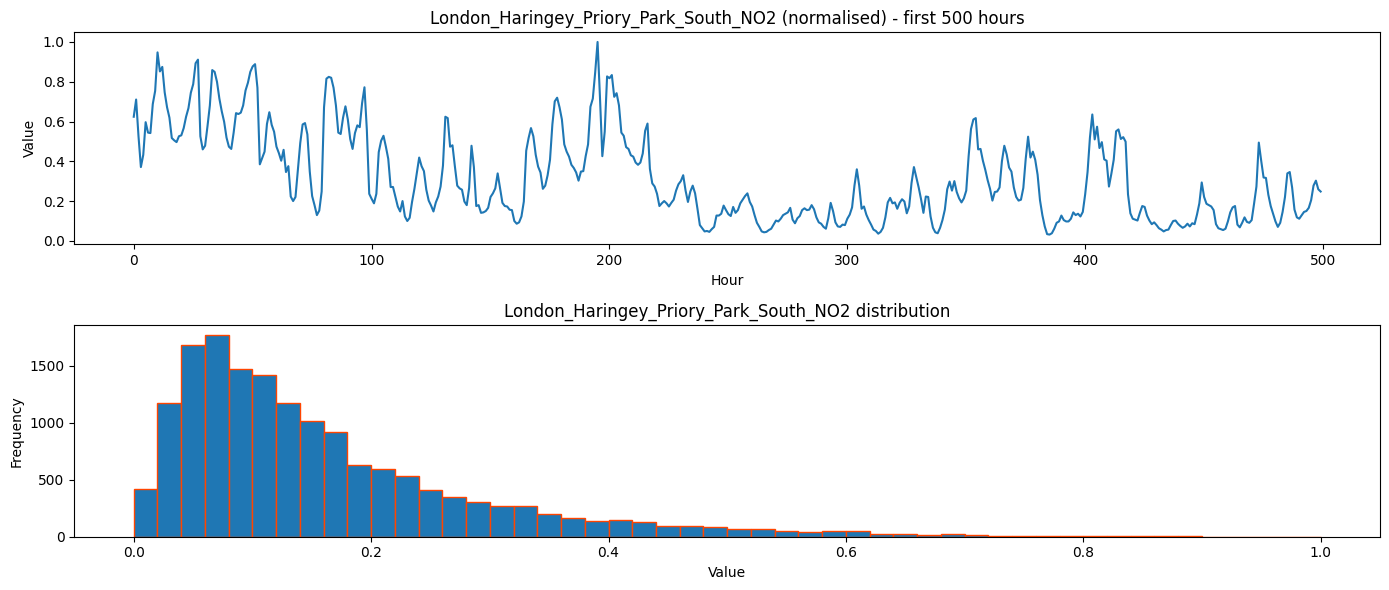

In [57]:
# Plot TARGET station, not just first NO2
sample_col = 'London_Haringey_Priory_Park_South_NO2'

fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Time series plot - first 500 hours
axes[0].plot(df_normalised[sample_col].values[:500])
axes[0].set_title(f'{sample_col} (normalised) - first 500 hours')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Value')

# Distribution plot
axes[1].hist(df_normalised[sample_col].values, bins=50, edgecolor='orangered')
axes[1].set_title(f'{sample_col} distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(visualisation_path / 'defra_data_overview.png', dpi=150)
plt.show()